<a href="https://colab.research.google.com/github/mkhfring/Tutorial/blob/master/maml-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Few-Shot Learning

Having looked at the pictures in the support set, you might easily label the animal in the query set as a Pangolin, even if you've never seen either Armadillos or Pangolins before. This ability to recognize the label of a query example based on just one or a few examples — a task that is typically easy for humans — is called few-shot learning. In few-shot learning, the amount of labeled data is extremely limited; only a handful of labeled examples are available. This is in contrast to transfer learning, where the model might fine-tune using thousands of labeled examples. In few-shot learning, the number of classes in the support set is referred to as "ways," and the number of examples in each class is called "shots." Thus, the picture below illustrates a 2-way 2-shot learning scenario.

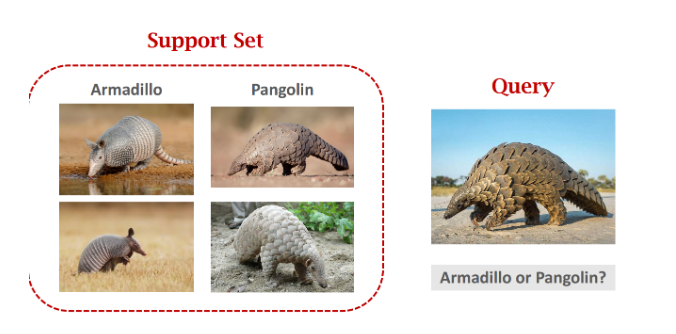

Few-shot learning methods can be divided into classical methods and prompt-based few-shot learning. Classical methods themselves can be classified as:

* Metric-based methods (e.g., matching networks): These aim to learn a metric to compare the examples.
* Parameter-based methods (e.g., prototypical networks): These aim to find an embedding for each class (prototypes) in the support set and then compare samples in the query set to each prototype.
* Optimization-based methods (e.g., Model-Agnostic Meta-Learning): These learn the parameters of the model in a way that allows it to be transferred to a new task using a few gradient steps.

This tutorial will cover Model-Agnostic Meta-Learning (MAML) for code clone detection








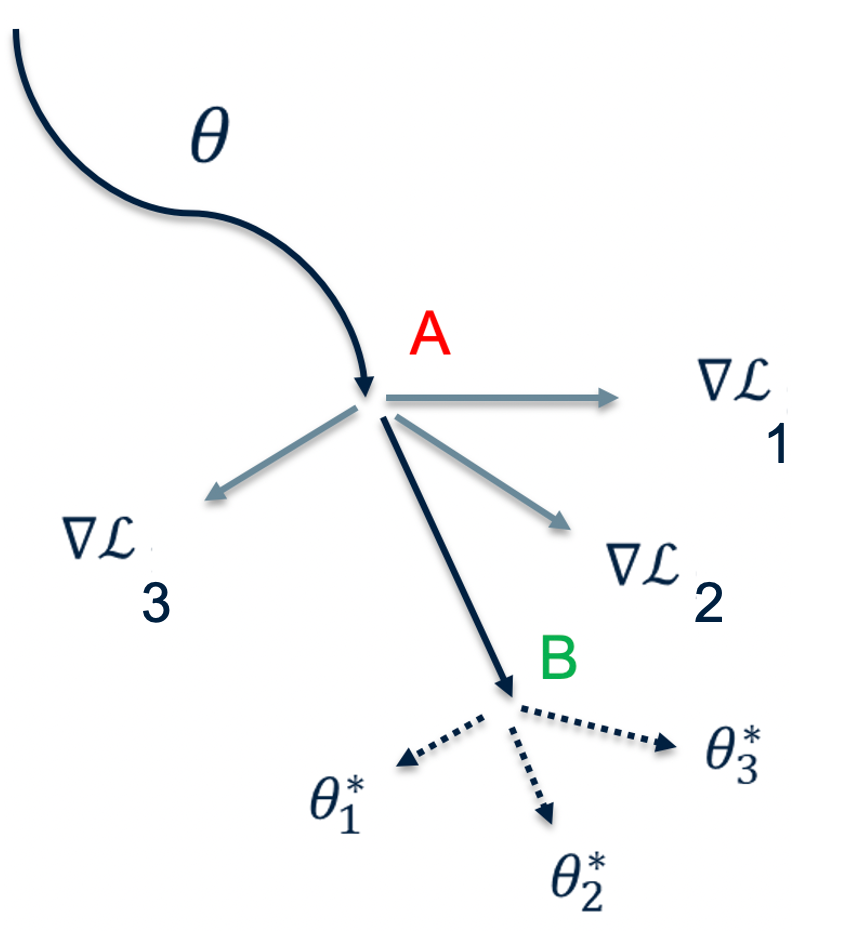

**Intuition**: Consider a model parameterized by Θ. If we have three distinct tasks directed by the gradients ∇Ł_1, ∇Ł_2, and ∇Ł_3, the accuracy may not be satisfactory. The core concept of MAML (Model-Agnostic Meta-Learning) is to shift the model's parameters from point A to point B, positioning them closer to these three tasks. By doing so, we can transition to each task with just a few gradient steps.The image below shows the MAML algorithm.

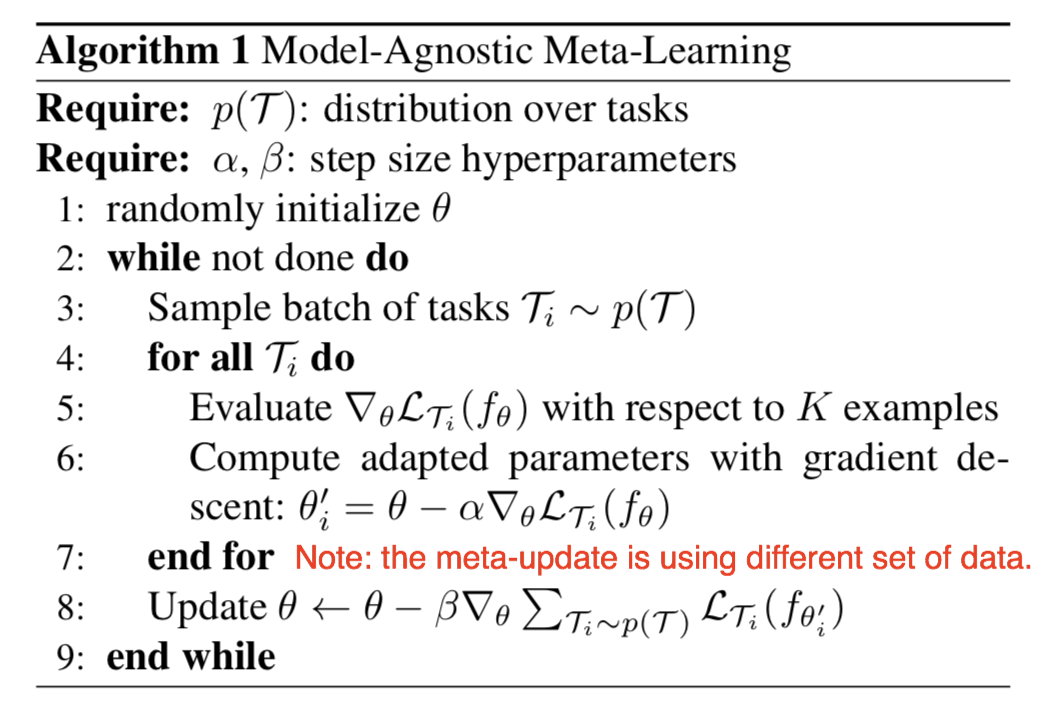

**MAML Overview:**

1- **Initialization:** Start with a model with parametersθ. This model serves as an initial model for various tasks.

2- **Task-Specific** Learning: For each task i:
* Use the current parameters θ to perform a few gradient updates specific to that task, resulting in task-specific parameters Θ'<sub><sup>i

* These updates are typically done using a small set of examples from the task, often referred to as the "support set."

3- **Meta Update:** After processing a batch of tasks, update the initial model parameters θ based on how well each Θ<sub><sup>i'

performed on its corresponding task. This is done by evaluating each Θ'<sub><sup>i

 on a separate set of examples from its task (often called the "query set"). The idea is to adjust such that a few task-specific gradient steps would lead to good generalization on new tasks.

Now, lets implement MAML for code clone detection. In this taks, we will be using BigClone Bench as the Meta training examples and POJ-104 as the downstream task

In [ ]:
!git clone https://github.com/mkhfring/Tutorial.git

Installing required packages:

In [ ]:
!pip install transformers
!pip install torch
!pip install datasets



For this tutorial, we've created a simplified version of the mentioned datasets: 10,000 training samples and 1,000 test examples.

In [ ]:
import datasets
train_data = datasets.load_from_disk('Tutorial/data/train_clone')

In [ ]:
import datasets

test_data = datasets.load_dataset('json', data_files={'test': 'Tutorial/data/test_clone.jsonl'})

In [ ]:
test_data

In [ ]:
test_data['test'][0]


In [ ]:
train_data[0]

In [ ]:
train = train_data
import pandas as pd
train_df = pd.DataFrame(train)
text = train_df["func1"]+ train_df["func2"]
train_df['text'] = text


In [ ]:
test = test_data["test"]
import pandas as pd
test_df = pd.DataFrame(test)
text = test_df["func1"]+ test_df["func2"]
test_df['text'] = text

We need to map the labels of our datasets

In [ ]:
train_df['label'] = train_df["label"].replace({True:"T", False:"F"})


In [ ]:
train_df

In [ ]:
test_df['label'] = test_df["label"].replace({True:"T", False:"F"})

In [ ]:
test_df

## Creating meta learning tasks

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import collections
import random
import json, pickle
from torch.utils.data import TensorDataset

LABEL_MAP  = {'positive':0, 'negative':1, 0:'positive', 1:'negative'}
LABEL_MAP  = { 'T':0, 'F':1, 0:'T', 1:'F'}
class MetaTask(Dataset):

    def __init__(self, examples, num_task, k_support, k_query, tokenizer):
        """
        :param samples: list of samples
        :param num_task: number of training tasks.
        :param k_support: number of support sample per task
        :param k_query: number of query sample per task
        """
        self.examples = examples
        random.shuffle(self.examples)

        self.num_task = num_task
        self.k_support = k_support
        self.k_query = k_query
        self.tokenizer = tokenizer
        # This part has been changed for the perpous of training with code
        # self.max_seq_length = 128
        self.max_seq_length = 512

        self.create_batch(self.num_task)

    def create_batch(self, num_task):
        self.supports = []  # support set
        self.queries = []  # query set

        for b in range(num_task):  # for each task
            # 1.select domain randomly
            #domain = random.choice(self.examples)['domain']
            #domainExamples = [e for e in self.examples if e['domain'] == domain]
            domainExamples = [e for e in self.examples]

            # 1.select k_support + k_query examples from domain randomly
            selected_examples = random.sample(domainExamples,self.k_support + self.k_query)
            random.shuffle(selected_examples)
            exam_train = selected_examples[:self.k_support]
            exam_test  = selected_examples[self.k_support:]

            self.supports.append(exam_train)
            self.queries.append(exam_test)

    def create_feature_set(self,examples):
        all_input_ids      = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_attention_mask = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_segment_ids    = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_label_ids      = torch.empty(len(examples), dtype = torch.long)

        for id_,example in enumerate(examples):
          # I have changed this part of the code
          #  input_ids = tokenizer.encode(example['text'])
            input_ids = tokenizer.encode(example['text'], max_length=128, truncation=True)

            attention_mask = [1] * len(input_ids)
            segment_ids    = [0] * len(input_ids)

            while len(input_ids) < self.max_seq_length:
                input_ids.append(0)
                attention_mask.append(0)
                segment_ids.append(0)

            #print("Check point for lables")

            label_id = LABEL_MAP[example['label']]
            all_input_ids[id_] = torch.Tensor(input_ids).to(torch.long)
            all_attention_mask[id_] = torch.Tensor(attention_mask).to(torch.long)
            all_segment_ids[id_] = torch.Tensor(segment_ids).to(torch.long)
            all_label_ids[id_] = torch.Tensor([label_id]).to(torch.long)


        tensor_set = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        return tensor_set

    def __getitem__(self, index):
        support_set = self.create_feature_set(self.supports[index])
        query_set   = self.create_feature_set(self.queries[index])
        return support_set, query_set

    def __len__(self):
        # as we have built up to batchsz of sets, you can sample some small batch size of sets.
        return self.num_task

**Overview:**

The above Python class, MetaTask, represents a dataset object tailored for few-shot learning tasks. In few-shot learning, there are two sets of data: support and query. The support set is a small set of labeled examples that helps the model adjust to a new task, while the query set is used to test the model's performance on that task.

**Details:**

1- **Initialization** (__init__ method):

* **examples:** List of all examples available.

* **num_task:** Total number of tasks.

* **k_support:** Number of samples in the support set for each task.

* **k_query:** Number of samples in the query set for each task.

* **tokenizer:** An object or function that processes the raw data into tokens (e.g., turning sentences into token arrays).
* The dataset samples (examples) are shuffled.
* Maximum sequence length for tokenization is set to 512.
* **create_batch** method is invoked to pre-generate tasks.

2- **Task Creation (create_batch method):**

* This method prepares the support and query sets for each task.
* It selects examples for each task and divides them into the support and query sets.


3- **Feature Creation (create_feature_set method):**

* This function processes a given set of examples, converting raw data into tokenized format suitable for models like BERT and CodeBERT.

* Tokenized sequences, attention masks, segment ids, and labels are created for each example.

* Sequences are padded to a consistent length (max_seq_length).

4- **Getting an Item (__getitem__ method):**

This allows the MetaTask object to be used like a list. When you request a particular index, it returns the support and query sets for the specified task.
It creates the features on-the-fly for both sets using the create_feature_set method.


5- **Length Method (__len__ method):**

* Returns the total number of tasks (or batches) available in this dataset object.

In essence, this class is built to handle few-shot learning scenarios, splitting given data into tasks and further into support and query sets, and providing tokenized input suitable for models like BERT.

## Split meta training and meta testing

In [ ]:

train_examples = train_df.to_dict('records')
test_examples = test_df.to_dict('records')


In [ ]:
len(test_examples)

In [ ]:
type(test_examples)
random.shuffle(test_examples)

In [ ]:
import torch
from transformers import BertModel, BertTokenizer, AutoTokenizer, RobertaConfig, RobertaTokenizer, RobertaModel
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
train = MetaTask(train_examples, num_task = 10, k_support=100, k_query=30, tokenizer = tokenizer)

In [ ]:
#Take a glance at the first two samples from support set of 1st meta-task
len(train.supports[0])

In [ ]:
# Let take a look at the first two samples from support set
train[0][0][:2]

## Training meta

In [ ]:
import time
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

def random_seed(value):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

def create_batch_of_tasks(taskset, is_shuffle = True, batch_size = 4):
    idxs = list(range(0,len(taskset)))
    if is_shuffle:
        random.shuffle(idxs)
    for i in range(0,len(idxs), batch_size):
        yield [taskset[idxs[i]] for i in range(i, min(i + batch_size,len(taskset)))]

class TrainingArgs:
    def __init__(self):
        self.num_labels = 2
        self.meta_epoch=2
        self.k_spt=80
        self.k_qry=20
        self.outer_batch_size = 2
        self.inner_batch_size = 12
        self.outer_update_lr = 5e-5
        self.inner_update_lr = 5e-5
        self.inner_update_step = 10
        self.inner_update_step_eval = 40
        self.bert_model = 'microsoft/codebert-base'
        self.num_task_train = 10
        self.num_task_test = 5

args = TrainingArgs()

## Create Meta Learner

In [ ]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification, RobertaModel, RobertaForSequenceClassification
from copy import deepcopy
import gc
from sklearn.metrics import accuracy_score
import torch
import numpy as np

class Learner(nn.Module):
    """
    Meta Learner
    """
    def __init__(self, args):
        """
        :param args:
        """
        super(Learner, self).__init__()

        self.num_labels = args.num_labels
        self.outer_batch_size = args.outer_batch_size
        self.inner_batch_size = args.inner_batch_size
        self.outer_update_lr  = args.outer_update_lr
        self.inner_update_lr  = args.inner_update_lr
        self.inner_update_step = args.inner_update_step
        self.inner_update_step_eval = args.inner_update_step_eval
        self.bert_model = args.bert_model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        #self.model = BertForSequenceClassification.from_pretrained(self.bert_model, num_labels = self.num_labels)
        #self.model = AutoModelForSequenceClassification.from_pretrained('mrm8488/codebert-base-finetuned-detect-insecure-code')
        self.model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base")
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.outer_update_lr)
        self.model.train()

    def forward(self, batch_tasks, training = True):
        """
        batch = [(support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset)]

        # support = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """
        task_accs = []
        sum_gradients = []
        num_task = len(batch_tasks)
        num_inner_update_step = self.inner_update_step if training else self.inner_update_step_eval

        for task_id, task in enumerate(batch_tasks):
            support = task[0]
            query   = task[1]

            fast_model = deepcopy(self.model)
            fast_model.to(self.device)
            support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                            batch_size=self.inner_batch_size)

            inner_optimizer = Adam(fast_model.parameters(), lr=self.inner_update_lr)
            fast_model.train()

            print('----Task',task_id, '----')
            for i in range(0,num_inner_update_step):
                all_loss = []
                for inner_step, batch in enumerate(support_dataloader):

                    batch = tuple(t.to(self.device) for t in batch)
                    input_ids, attention_mask, segment_ids, label_id = batch
                    outputs = fast_model(input_ids, attention_mask, segment_ids, labels = label_id)

                    loss = outputs[0]
                    loss.backward()
                    inner_optimizer.step()
                    inner_optimizer.zero_grad()

                    all_loss.append(loss.item())

                if i % 4 == 0:
                    print("Inner Loss: ", np.mean(all_loss))

            fast_model.to(torch.device('cpu'))

            if training:
                meta_weights = list(self.model.parameters())
                fast_weights = list(fast_model.parameters())

                gradients = []
                for i, (meta_params, fast_params) in enumerate(zip(meta_weights, fast_weights)):
                    gradient = meta_params - fast_params
                    if task_id == 0:
                        sum_gradients.append(gradient)
                    else:
                        sum_gradients[i] += gradient

            fast_model.to(self.device)
            fast_model.eval()
            with torch.no_grad():
                query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
                query_batch = next(iter(query_dataloader))
                query_batch = tuple(t.to(self.device) for t in query_batch)
                q_input_ids, q_attention_mask, q_segment_ids, q_label_id = query_batch
                q_outputs = fast_model(q_input_ids, q_attention_mask, q_segment_ids, labels = q_label_id)

                q_logits = F.softmax(q_outputs[1],dim=1)
                pre_label_id = torch.argmax(q_logits,dim=1)
                pre_label_id = pre_label_id.detach().cpu().numpy().tolist()
                q_label_id = q_label_id.detach().cpu().numpy().tolist()

                acc = accuracy_score(pre_label_id,q_label_id)
                task_accs.append(acc)

            fast_model.to(torch.device('cpu'))
            del fast_model, inner_optimizer
            torch.cuda.empty_cache()

        if training:
            # Average gradient across tasks
            for i in range(0,len(sum_gradients)):
                sum_gradients[i] = sum_gradients[i] / float(num_task)

            #Assign gradient for original model, then using optimizer to update its weights
            for i, params in enumerate(self.model.parameters()):
                params.grad = sum_gradients[i]

            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()

            del sum_gradients
            gc.collect()

        return np.mean(task_accs)

## Lets break down the Learner code to undrestand it better:

1- **Initialization of a Model:** In MAML, a single model is initialized, which is then fine-tuned on each task's support set. In the provided code, the model is initialized as `RobertaForSequenceClassification`.

2- **Inner Loop (Task-specific updates):** For each task, a copy of the model (`fast_model`) is created. This model is then trained on the support set of the task for a specified number of inner update steps (`num_inner_update_step`). This is consistent with MAML's inner loop.

3- **Outer Loop (Meta-update):** After the inner loop updates for all tasks, MAML computes the average gradient across all tasks and updates the original model. In the provided code, after processing all tasks, the average gradient is computed (`sum_gradients[i] = sum_gradients[i] / float(num_task)`) and used to update the original model (`self.outer_optimizer.step()`). This is consistent with MAML's outer loop.

4- Evaluation on Query Set: After the inner loop updates, the model is evaluated on the query set of each task to compute the task-specific accuracy. This is done in the code using the `fast_model` on the query set.

5- Gradient Calculation: In MAML, the gradient is computed based on the difference in performance on the query set before and after the inner loop updates. In the provided code, the gradient is calculated as the difference between the weights of the original model and the `fast_model` after inner updates (`gradient = meta_params - fast_params`). This is a simplified version of the gradient computation in MAML.



### Moreover, lets see what will happen in the testing:
1- **Training Flag:** The code uses a `training` flag in the `forward` method. If this flag is set to False (which would typically be the case during testing), the code will perform the inner loop updates for self.`inner_update_step_eval` steps. This means that the model will be updated based on the support set.

2- **Inner Loop Updates:** Within the `for i in range(0,num_inner_update_step):` loop, the model (`fast_model`) is updated based on the support set samples. This is the essence of the MAML algorithm, where the model is fine-tuned on the support set before being evaluated on the query set.

3- Query Set Evaluation: After the inner loop updates, the model is evaluated on the query set (which can be considered as the test samples in the context of each task). The model's parameters are not updated based on the query set.

Given the above points and ignoring the support set of the test set:



*  The model does not train on the query set (test samples). It only trains on the support set during the inner loop updates.
*  The model is evaluated on the query set without any further training on these samples.

So, the model does not train on the test samples (query set). It only trains on the support set during the inner loop updates.


In [ ]:
learner = Learner(args)

In [ ]:
random_seed(123)
test = MetaTask(test_examples, num_task =1, k_support=30, k_query=10, tokenizer = tokenizer)
random_seed(int(time.time() % 10))

## Start training

In [ ]:
global_step = 0
torch.cuda.empty_cache()

for epoch in range(args.meta_epoch):

    train = MetaTask(train_examples, num_task = 5, k_support=80, k_query=20, tokenizer = tokenizer)
    db = create_batch_of_tasks(train, is_shuffle = True, batch_size = args.outer_batch_size)

    for step, task_batch in enumerate(db):
        print(len(task_batch))
        f = open('log.txt', 'a')

        acc = learner(task_batch)

        print('Step:', step, '\ttraining Acc:', acc)
        f.write(str(acc) + '\n')

        if global_step % 20 == 0:
            random_seed(123)
            print("\n-----------------Testing Mode-----------------\n")
            db_test = create_batch_of_tasks(test, is_shuffle = False, batch_size = 1)
            acc_all_test = []

            for test_batch in db_test:
                acc = learner(test_batch, training = False)
                acc_all_test.append(acc)

            print('Step:', step, 'Test F1:', np.mean(acc_all_test))
            f.write('Test' + str(np.mean(acc_all_test)) + '\n')

            random_seed(int(time.time() % 10))

        global_step += 1
        f.close()